# Question 2 - Alex Bercik (1002128020) and Jaewon Yun (999243322)

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt

In this exercise we will explore image deconvolution, or ways to unblur an image. When a photograph is taken but a blur is introduced, we are able to correct the blur because all of the original data is still present in the photograph, it has simply bled into neighboring pixels. If we know the pattern of the blur we can work backwards to reconstruct the original unblurred photograph.

Mathematically we need a Point Spread Function that characterizes the blur. The blurred image is then created by convolving with the original image with the point spread function. By taking the fourier transform of the blurred image we can once again spearate the two, and isolate the fourier transform of the original image through
\begin{equation}
\widetilde{a}_{kl} = \frac{\widetilde{b}_{kl}}{KL \widetilde{f}_{kl}},
\end{equation}
where $\widetilde{a}_{kl}$ is the fourier transform of the original image, $\widetilde{b}_{kl}$ is the fourier transform of the blurred image, $\widetilde{f}_{kl}$ is the fourier transform of the point spread function, and $K \times L$ are the dimensions of the photograph (in pixels). We can simply take an inverse fourier transform of $\widetilde{a}_{kl}$ to recover our unblurred image. We now demonstrate an example of this deconvolution process.

# Part A

Here we read a text file with intensity values (monochromatic) that define an image. We store the values in a $K \times L$ array, then plot the photograph.

In [2]:
raw = np.loadtxt('blur.txt')

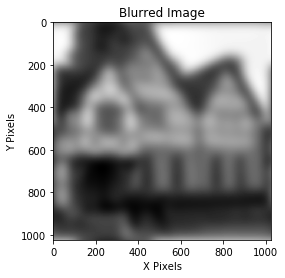

In [3]:
plt.figure()
plt.gray() # set the colour scheme as always grayscale
plt.imshow(raw) # plot our picture from text file
plt.title('Blurred Image')
plt.ylabel('Y Pixels')
plt.xlabel('X Pixels')
plt.show()

We see the result is a very blurry picture of a house. Let's see what we can do to unblur this photo.

Note: I left the axes on to label the pixels, but I could have taken them off using:
```python
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
```

# Part B

In order to unblur the image, we need to have a well-defined point spread function. This is where the difficulty usually comes in, but to simplify the process we are assuming a perfect universe where an all omnipotent being has gifted us with a well known point spread function: A gaussian with sigma=25

To make things even better, the code for the gaussian was given to us in the write-up of the lab. How marvelous!

In [4]:
# Define a function to make a Gaussian PSF

def makeGaussianPSF(sigma,array):
    """ Returns a normalized 2D gaussian point spread function 
    INPUT: sigma, blurry image (to copy shape of array)
    OUTPUT: array of same size as input that defines Gaussian """   
    # initialize gaussian array of same size as input array
    gauss = np.empty(np.shape(array))
    rows = len(gauss[0]) # store dimensions
    cols = len(gauss)
    # loop for all indices in gaussian
    # NOTE: We choose to use a mirror flipped gaussian (why I don't know...)
    # but this means we define indices using their mirrored values
    for i in range(rows):
        ip = i
        if ip > rows/2:
            ip -= rows # bottom half of rows moved to negative values
        for j in range(cols):
            jp = j
            if jp > cols/2:
                jp -= cols # right half of columns moved to negative values
            # Now we compute the gaussian
            gauss[i, j] = np.exp(-(ip**2 + jp**2)/(2.*sigma**2))
    return gauss

In [5]:
# define our gaussian point spread function with sigma = 25
gauss = makeGaussianPSF(25,raw)

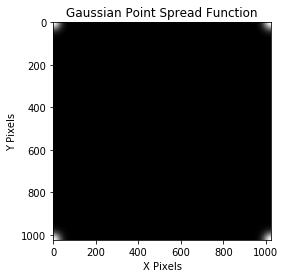

In [6]:
plt.figure()
plt.imshow(gauss) # plot our gaussian point spread function
plt.title("Gaussian Point Spread Function")
plt.ylabel('Y Pixels')
plt.xlabel('X Pixels')
plt.show()

Here is the plot of our Gaussian Point Spread Function. Once again, I'm not sure exactly why we chose to do one with the maximum mirrored onto the corners (as opposed to being in the centre), but it's just a convention thing. The point is that this is what we wanted to see.

Note: Once again I have left ticks for the pixels.

# Part C

Now comes the part where we do the magic - we use the formula $\widetilde{a}_{kl} = \frac{\widetilde{b}_{kl}}{KL \widetilde{f}_{kl}}$ to deconvolve our image.

We will define a function to perform the operation. The trick in this function comes in the cases when the gaussian point spread function is 0. In this case we find ourselves dividing by zero, and of course this is an issue when we go to compute the inverse fourier transform. To get around this issue then we check when the values of the gaussian point spread function are small ($ < 1 \times 10^{-3}$). When this happens we only divide by the dimensions, essentially throwing away some information in the photograph to preserve the overall transform. As a result our deconvolved image will remain slightly blurry.

In [11]:
def deconvolve(image, psf):
    """ Returns the deconvolved (unblurry) photograph
    INPUT: array of convolved (blurry) image, array of point
           spread function
    OUTPUT: array of deconvolved (unblurry) photograph """ 
    image_fft = np.fft.fft2(image) # fourier transform blurry image
    psf_fft = np.fft.fft2(psf) # fourier transform point spread function
    # create array for fourier transform of deconvolved (oringinal) image
    deconvolved_fft = np.empty(np.shape(image_fft),dtype=complex)
    for x in range(len(image_fft)):
        for y in range(len(image_fft[0])): # loop for all indices
            # only divide by gaussian fft if the values are non-zero
            if abs(psf_fft[x][y]) > 1e-3:
                # divide according to the equation given
                deconvolved_fft[x][y] = image_fft[x][y]/(psf_fft[x][y]* \
                                                         len(psf[0])*len(psf))
            # otherwise, simply divide by the dimensions
            else: deconvolved_fft[x][y] = image_fft[x][y]/(len(psf[0])*len(psf))
    # Recover deconvolved image by taking the inverse fourier transform
    deconvolved = np.abs(np.fft.ifft2(deconvolved_fft))
    return deconvolved # return deconvolved image

In [8]:
# call function above using our raw input and gaussian point spread function
deconvolved = deconvolve(raw, gauss)

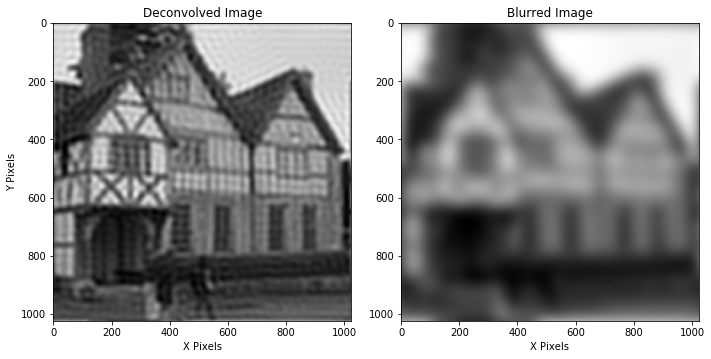

In [9]:
# Plot the result!
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)

# Plot the deconvolved image
ax1.imshow(deconvolved)
ax1.set_title('Deconvolved Image')
ax1.set_ylabel('Y Pixels')
ax1.set_xlabel('X Pixels')

# As a reminder from where we started, let's plot the original image as well
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(raw)
ax2.set_title('Blurred Image')
ax2.set_xlabel('X Pixels')
plt.tight_layout()
plt.show()

The result is a nice photo where we can make out the result! We have thus demonstrated the process of deconvolution wen we know the point spread function.

# Extra

After completing the exercise, I found a different method online for dealing with the problem of dividing by zero. Instead of removing the problematic pixels, the solution was to adda constant (small) epsilon to the entire fourier transform of the point spread function, eliminating the problem of having value-0 elements altogether. This has an interesting consequence in that varying the value of epsilon gives very different results. When we have a large epsilon, we are essentially adding in more frequencies to the point spread function. This takes us away from our ideal point spread function and thus makes the deconvolution less effective, resulting in a blurry photograph. On the other hand, a very small epsilon means we divide by a very large number, and as such we amplify noise. The result is a photograph dominated entirely by noise. We thus are left with a result that is very dependant on our choice of epsilon!

This ties in to part (d) of the question: When we do the deconvolution, we have to at some point throw away some of our information. Whether we do this by ommiting the point spread function in the division, or alternatively adding a constant epsilon to change the point spread function, the end result is that our deconvolution is not perfect. The conclusion is that our deconvolved image will never be perfect and will always remain slightly blurry. The best we can do is try to minimize the loss of this information, and in this regard there is a lot of things people have done to investigate this. That of course goes way beyond this lab.

If the reader is curious, I provide below a slightly modified script I found online to perform the deconvolution using the second method explained above. The result can be plotted using the same code in the rest of the notebook.

In [10]:
# epsilon = 0.00001 gives noisy image
# epsilon = 0.001 gives good image
# epsilon = 0.1 gives blurry image
def deconvolve(Input, psf, epsilon):
    InputFFT = np.fft.fft2(Input)
    psfFFT = np.fft.fft2(psf)+epsilon
    deconvolved = np.fft.ifft2(InputFFT/psfFFT)
    deconvolved = np.abs(deconvolved)
    return(deconvolved)

deconvolved = deconvolve(raw, gauss, 0.001)